In [1]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import levene
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy import stats

In [2]:
all_data = pd.read_csv('final_data_full.csv', sep=",", encoding='cp1252')
all_data = all_data.dropna(how='all')

In [3]:
all_data = all_data.rename(columns={"no": "condition", "Entry no": "participant", "measure_post ":'measure_post'})
all_data['condition'] = all_data['condition'].apply(lambda x: x[-1])

# conditions are numbered for now (condition_3 is third-person intervention)
def condition_values(value):
    if value == 'A':
        return 'condition_1'
    elif value == 'B':
        return 'condition_2'
    elif value == 'C':
        return 'condition_3'
    else:
        return 'control'
all_data.condition = all_data.condition.apply(condition_values)

#fixing time
to_time = lambda x: pd.to_timedelta('00:'+x)
def time_fix(value):
    for i in value:
        if i in [',', '.']:
            mins, secs = value.split(i)
    return float("{0:.2f}".format(float(mins) + (float(secs)/ 60)))

all_data.measure_past = all_data.measure_past.astype(str).apply(time_fix)
all_data.measure_pre = all_data.measure_pre.astype(str).apply(time_fix)
all_data.measure_post = all_data.measure_post.astype(str).apply(time_fix)
all_data.measure_actual = all_data.measure_actual.astype(str).apply(time_fix)

#simplifying condition into experimental and control
def condition(condition):
    if condition == 'control':
        return 'control'
    else:
        return 'experiment'
all_data['simple_condition'] = [condition(x) for x in all_data['condition']] # this is for H1

# adding the variable of discrepancy => "error" (= actual measure - post intervention estimate) - our main experimental focus
all_data['error'] = all_data['measure_actual'] - all_data['measure_post']

-----------------------------------

<div style="background-color: lightblue; padding: 10px;">
    
# Part 1: Demographics (Descriptive Stats)

## 1) Gender

In [4]:
# table for all conditions
gender_data = all_data[['condition','gender']].groupby('condition')\
.value_counts().to_frame().reset_index()\
.pivot(index='gender', columns='condition', values='count')\
.fillna(0).astype(int).reset_index()

# overall stats
gender_data['overall'] = gender_data[['condition_1', 'condition_2', 'condition_3', 'control']].sum(axis=1).astype(int)

# counting rsd
gender_vs = []
for i in range(gender_data['gender'].nunique()):
    stds = gender_data[['condition_1', 'condition_2', 'condition_3', 'control']].iloc[i].std()
    means = gender_data[['condition_1', 'condition_2', 'condition_3', 'control']].iloc[i].mean()
    #print(f"RSD for {gender_data['gender'].unique()[i]}: {((stds/means) * 100):.2f}%")
    gender_vs.append(f"{((stds/means) * 100):.2f}%")
gender_data['rsd'] = gender_vs

def highlight1(val):
    return 'background-color: #e0e0e0'
def highlight2(val):
    return 'background-color: #d0d0d0'

#styling table
gender_data.columns.name = None
gender_data = gender_data.style\
.set_caption("<b>Table 1. Gender Statistics<b>")\
.map(highlight2, subset=['overall'])\
.map(highlight1, subset=['rsd'])

gender_data

,gender,condition_1,condition_2,condition_3,control,overall,rsd
0,Female,14,8,11,10,43,23.26%
1,Male,1,5,4,5,15,50.48%
2,Non-binary,0,2,0,0,2,200.00%


## 2) Age

In [5]:
# table for all conditions
age_data = all_data[['age', 'condition']].groupby('condition')\
.agg({'age':['mean', lambda x: x.max()-x.min()]}).astype(int)
age_data.columns = ['mean_age', 'age_range']
age_data = age_data.T

# overall stats
age_all = all_data['age'].agg(['mean', lambda x: x.max()-x.min()])\
.to_frame().astype(float)['age'].to_list()
age_data['overall'] = ["{:.2f}".format(x) for x in age_all]

# counting rsd
rsd_age = (all_data['age'].std() / all_data['age'].mean()) * 100
print(f"RSD of age: {rsd_age:.2f}%")

#styling table
age_data.columns.name = None
age_data = age_data.style\
.set_caption("<b>Table 2. Age Statistics<b>")\
.map(highlight2, subset=['overall'])

age_data

RSD of age: 4.29%


,condition_1,condition_2,condition_3,control,overall
mean_age,21,21,21,21,21.58
age_range,4,2,3,4,5.00


## 3) Ethnicity

In [6]:
# table for all conditions
ethnicity_data = all_data[['condition', 'ethnicity']].groupby('condition')\
.value_counts().to_frame().reset_index()\
.pivot(index='ethnicity', columns='condition', values='count')\
.fillna(0).astype(int).reset_index()

# overall stats
ethnicity_all = all_data['ethnicity'].value_counts()\
.to_frame().reset_index().sort_values(by='ethnicity')['count'].to_list()
ethnicity_data['overall'] = [int(x) for x in ethnicity_all]

# counting rsd
ethnicity_vs = []
for i in range(ethnicity_data['ethnicity'].nunique()):
    stds = ethnicity_data[['condition_1', 'condition_2', 'condition_3', 'control']].iloc[i].std()
    means = ethnicity_data[['condition_1', 'condition_2', 'condition_3', 'control']].iloc[i].mean()
    #print(f"RSD for {
    #ethnicity_data.reset_index()['ethnicity'].unique()[i]
    #}: {((stds/means)*100):.2f}%")
    ethnicity_vs.append(f"{((stds/means) * 100):.2f}%")
ethnicity_data['rsd'] = ethnicity_vs
ethnicity_data.columns.name = None

#styling table
ethnicity_data = ethnicity_data.style\
.set_caption("<b>Table 3. Ethnicity Statistics<b>")\
.map(highlight2, subset=['overall'])\
.map(highlight1, subset=['rsd'])

ethnicity_data

,ethnicity,condition_1,condition_2,condition_3,control,overall,rsd
0,Arab,0,0,1,0,1,200.00%
1,Asian,0,2,3,1,6,86.07%
2,Black/African/Caribbean,0,0,1,0,1,200.00%
3,Mixed/Multiple Ethnic Groups,1,1,2,0,4,81.65%
4,White,14,12,8,14,48,23.57%


## 4) Skills and Familiriarity


In [7]:
# table for all conditions
skills_table = all_data.groupby(['condition','skills']).agg({'skills':'count'})\
.rename(columns={'skills':'count'}).reset_index()\
.pivot(index='skills',columns='condition',values='count')\
.fillna(0).astype(int).reset_index()

# overall stats
skills_table['overall'] = all_data['skills'].value_counts()\
.to_frame().sort_values(by='skills')['count'].to_list()

# counting rsd
skills_vs = []
for i in range(skills_table['skills'].nunique()):
    stds = skills_table[['condition_1', 'condition_2', 'condition_3', 'control']].iloc[i].std()
    means = skills_table[['condition_1', 'condition_2', 'condition_3', 'control']].iloc[i].mean()
    #print(f"RSD for {
    #skills_table.reset_index()['skills'].unique()[i]
    #}: {((stds/means)*100):.2f}%")
    skills_vs.append(f"{((stds/means) * 100):.2f}%")
skills_table['rsd'] = skills_vs
skills_table.columns.name = None

#styling table
skills_table = skills_table.style\
.set_caption("<b>Table 4. Presentation Skills Statistics<b>")\
.map(highlight2, subset=['overall'])\
.map(highlight1, subset=['rsd'])

skills_table

,skills,condition_1,condition_2,condition_3,control,overall,rsd
0,Advanced,4,8,9,6,27,32.85%
1,Beginner,0,0,1,0,1,200.00%
2,Expert,0,6,1,3,10,105.83%
3,Intermediate,11,1,4,6,22,76.42%


----

In [8]:
# table for all conditions
familiarity_table = all_data.groupby(['condition','familiarity']).agg({'familiarity':'count'})\
.rename(columns={'familiarity':'count'}).reset_index()\
.pivot(index='familiarity',columns='condition',values='count')\
.fillna(0).astype(int).reset_index()

# overall stats
familiarity_table['overall'] = all_data['familiarity'].value_counts()\
.to_frame().sort_values(by='familiarity')['count'].to_list()

# counting rsd
familiarity_vs = []
for i in range(familiarity_table['familiarity'].nunique()):
    stds = familiarity_table[['condition_1', 'condition_2', 'condition_3', 'control']].iloc[i].std()
    means = familiarity_table[['condition_1', 'condition_2', 'condition_3', 'control']].iloc[i].mean()
    #print(f"RSD for {
    #familiarity_table.reset_index()['familiarity'].unique()[i]
    #}: {((stds/means)*100):.2f}%")
    familiarity_vs.append(f"{((stds/means) * 100):.2f}%")
familiarity_table['rsd'] = familiarity_vs
familiarity_table.columns.name = None

#styling table
familiarity_table = familiarity_table.style\
.set_caption("<b>Table 5. Task Familiarity Statistics<b>")\
.map(highlight2, subset=['overall'])\
.map(highlight1, subset=['rsd'])

familiarity_table

,familiarity,condition_1,condition_2,condition_3,control,overall,rsd
0,Moderately Familiar,9,0,8,4,21,78.34%
1,Somewhat Familiar,1,0,3,2,6,86.07%
2,Very Familiar,5,15,4,9,33,60.50%


## 5) Motivation and Confidence


In [9]:
# table for all conditions
motivation_table = all_data.groupby(['condition','motivation']).agg({'motivation':'count'})\
.rename(columns={'motivation':'count'}).reset_index()\
.pivot(index='motivation',columns='condition',values='count')\
.fillna(0).astype(int).reset_index()

# overall stats
motivation_table['overall'] = all_data['motivation'].value_counts()\
.to_frame().sort_values(by='motivation')['count'].to_list()

# counting rsd
motivation_vs = []
for i in range(motivation_table['motivation'].nunique()):
    stds = motivation_table[['condition_1', 'condition_2', 'condition_3', 'control']].iloc[i].std()
    means = motivation_table[['condition_1', 'condition_2', 'condition_3', 'control']].iloc[i].mean()
    #print(f"RSD for {
    #motivation_table.reset_index()['motivation'].unique()[i]
    #}: {((stds/means)*100):.2f}%")
    motivation_vs.append(f"{((stds/means) * 100):.2f}%")
motivation_table['rsd'] = motivation_vs
motivation_table.columns.name = None

#styling table
motivation_table = motivation_table.style\
.set_caption("<b>Table 6. Motivation Statistics<b>")\
.map(highlight2, subset=['overall'])\
.map(highlight1, subset=['rsd'])

motivation_table

,motivation,condition_1,condition_2,condition_3,control,overall,rsd
0,Extremely,3,0,0,2,5,120.00%
1,Moderately,8,9,3,6,26,40.70%
2,Not at all,1,0,4,1,6,115.47%
3,Slightly,2,4,7,4,17,48.51%
4,Very,1,2,1,2,6,38.49%


In [10]:
# cleansing spelling error
all_data.loc[all_data['confidence_guess'] == 'Exteremly', ['condition', 'confidence_guess']] = ['condition_1', 'Extremely']

# table for all conditions
confidence_table = all_data.groupby(['condition','confidence_guess']).agg({'confidence_guess':'count'})\
.rename(columns={'confidence_guess':'count'}).reset_index()\
.pivot(index='confidence_guess',columns='condition',values='count')\
.fillna(0).astype(int).reset_index()

# overall stats
confidence_table['overall'] = all_data['confidence_guess'].value_counts()\
.to_frame().sort_values(by='confidence_guess')['count'].to_list()

# counting rsd
confidence_vs = []
for i in range(confidence_table['confidence_guess'].nunique()):
    stds = confidence_table[['condition_1', 'condition_2', 'condition_3', 'control']].iloc[i].std()
    means = confidence_table[['condition_1', 'condition_2', 'condition_3', 'control']].iloc[i].mean()
    #print(f"RSD for {
    #confidence_table.reset_index()['confidence_guess'].unique()[i]
    #}: {((stds/means)*100):.2f}%")
    confidence_vs.append(f"{((stds/means) * 100):.2f}%")
confidence_table['rsd'] = confidence_vs
confidence_table.columns.name = None

#styling table
confidence_table = confidence_table.style\
.set_caption('<b>Table 7. Confidence Statistics<b>')\
.map(highlight2, subset=['overall'])\
.map(highlight1, subset=['rsd'])

confidence_table

,confidence_guess,condition_1,condition_2,condition_3,control,overall,rsd
0,Extremely,1,0,0,1,2,115.47%
1,Moderately,9,11,5,7,32,32.27%
2,Not at all,1,0,0,0,1,200.00%
3,Slightly,2,2,4,4,12,38.49%
4,Very,2,2,6,3,13,58.25%


<div style="background-color: lightblue; padding: 10px;">

# Part 2: Experimental Data (Inferential Stats)

## Hypothesis 1: Prediction-Actual Time Discrepancy in Intervention VS. Controls

> H1: Significant difference in `error` between control and experimental conditions <p>
> H0: No significant difference in `error`

**For the statistical test (such as ANOVA) we normally need to check:**

1) Normal distribution in the samples - Shapiro-Wilk test
2) Homogeneity of variance - Levin's test

(In both tests we assume p>0.05 is satisfactory to proceed to ANOVA)

In [11]:
hyp1_data = all_data[['simple_condition', 'error']]
experiment = hyp1_data.query('simple_condition=="experiment"')['error']
control = hyp1_data.query('simple_condition=="control"')['error']

Next, we're checking for homogeneity of variance and normality(!)

In [12]:
# checking for homogeneity of variance
stat, p = levene(control, experiment)
print(f"1) Levene’s Test p-value: {p}")
print(f"Homogeneity: {p>0.05}")

# checking for normal distribution
print(f"\n2) Shapiro Test p-value for control group: {shapiro(control).pvalue}")
print(f"3) Shapiro Test p-value for experimental: {shapiro(experiment).pvalue}")
print(f"Normality: {shapiro(control).pvalue>0.05 and shapiro(experiment).pvalue>0.05}")

1) Levene’s Test p-value: 0.9008353466325039
Homogeneity: True

2) Shapiro Test p-value for control group: 0.09055841577044696
3) Shapiro Test p-value for experimental: 0.04277747303125376
Normality: False


**Experimental group is not normally distributed**

Although ANOVA is not particularly sensitive to non-normal distributions, the test can still give a false positive result.
Instead, we can use Mann-Whitney test of significant difference.

In [13]:
# Mann-Whitney Stat Test
u, p = mannwhitneyu(control, experiment)
print(f"Mann-Whitney Test p-value: {p}")
print(f"Significance: {p<0.05}")

Mann-Whitney Test p-value: 3.47344959221516e-05
Significance: True


So, our results are statistically significant. We'll now find medians + stds for the data

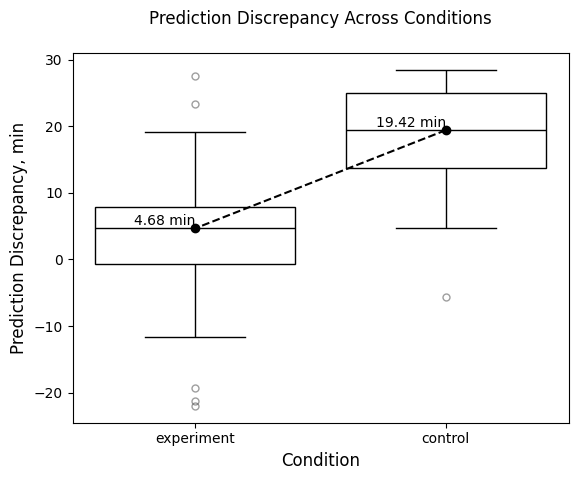

In [14]:
# calculating meadians and std
h1_medians = hyp1_data.groupby('simple_condition').agg({'error':'median'})\
.reset_index().rename(columns={'error':'medians'})
h1_medians['std'] = [control.std(), experiment.std()]

# plotting plotting plotting
sns.boxplot(x = 'simple_condition', y = 'error', data = hyp1_data, 
            boxprops=dict(facecolor="white", edgecolor="black"), 
            whiskerprops=dict(color="black"), capprops=dict(color="black"),
            medianprops=dict(color="black"), flierprops=dict(marker='o', markersize=5, alpha=0.5))

plt.plot(h1_medians.simple_condition, h1_medians.medians, color='black', linestyle='--', marker='o')

for i, txt in enumerate(h1_medians.medians):
    plt.text(h1_medians.simple_condition[i], h1_medians.medians[i], f'{txt:.2f} min', 
             ha='right', va='bottom', color='black', fontsize=10)

plt.xlabel("Condition", fontsize=12)
plt.ylabel("Prediction Discrepancy, min", fontsize=12)
plt.title("Prediction Discrepancy Across Conditions\n", fontsize=12)

plt.show()

In [15]:
h1_medians

,simple_condition,medians,std
0,control,19.42,9.443981
1,experiment,4.68,10.088471


### Result: Statistically Significant Difference!

**We reject H0** - There is a significant difference in `error` between control and experimental group errors

- See table `h1_medians` with medians and std for concrete numbers


## Hypothesis 2*: Third-Person VS Other Interventions

> H1: Significant difference in `error` between 3rd person VS other interventions <p>
> H0: No significant difference in `error`

*This is your previous H2

In [16]:
# dividing sample of experimental group into third-person and non-third-person
def h2_condition(condition):
    if condition == 'condition_3':
        return 'third_person'
    else:
        return 'other'

h2_data = all_data[['condition', 'simple_condition', 'error']].copy()
h2_data['h2_condition'] = all_data['condition'].apply(h2_condition)
h2_data = h2_data.drop(['condition', 'simple_condition'], axis=1)

# our 2 conditions
experimental = h2_data.query('h2_condition=="other"')['error']
third_person = h2_data.query('h2_condition=="third_person"')['error']

In [17]:
# Checking for homogeneity of variance
stat, p = levene(experimental, third_person)
print(f"1) Levene’s Test p-value: {p}")
print(f"Homogeneity: {p>0.05}")

# Checking for normal distribution
print(f"\n2) Shapiro Test p-value for other conditions: {shapiro(experimental).pvalue}")
print(f"3) Shapiro Test p-value for third-person condition: {shapiro(third_person).pvalue}")
print(f"Normality: {shapiro(experimental).pvalue>0.05 and shapiro(third_person).pvalue>0.05}")

1) Levene’s Test p-value: 0.01287595268451639
Homogeneity: False

2) Shapiro Test p-value for other conditions: 0.14246854326816194
3) Shapiro Test p-value for third-person condition: 0.9945882179153058
Normality: True


**Our samples don't have homogenous variance**

But they are normally distributed, which means we can just apply t-test with a specification of no equal variance (Welch's t-test)

In [18]:
# Welch's T-test
_, p = stats.ttest_ind(experimental, third_person, equal_var=False)
print(f"Welch's t-test p-value: {p}")
print(f"Significance: {p<0.05}")

# And just to compare it with Mann-Whitney (it also works here)
# Mann-Whitney
u, p = mannwhitneyu(experimental, third_person)
print(f"\nMann-Whitney Test p-value: {p}")
print(f"Significance: {p<0.05}")

Welch's t-test p-value: 0.2341591429219533
Significance: False

Mann-Whitney Test p-value: 0.25269501277998485
Significance: False


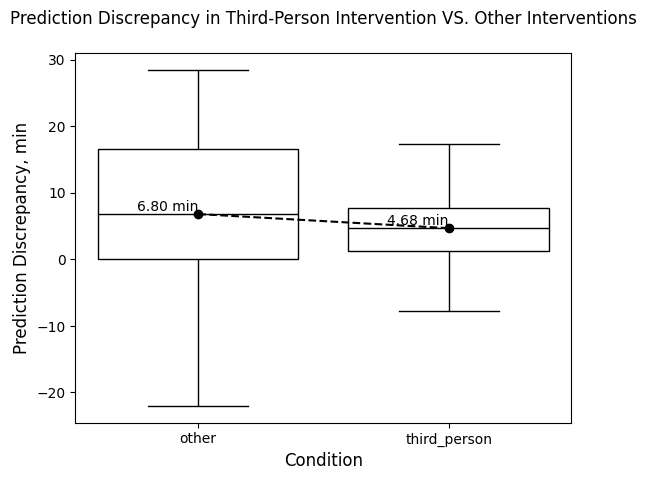

In [19]:
# medians and stds
h2_medians = h2_data.groupby('h2_condition').agg({'error':'median'}).reset_index()
h2_medians['std'] = [experimental.std(), third_person.std()] 
h2_medians = h2_medians.rename(columns={'h2_condition':'condition', 'error':'medians'})

# plotting plotting plotting
sns.boxplot(x = 'h2_condition', y = 'error', data = h2_data, 
            boxprops=dict(facecolor="white", edgecolor="black"), 
            whiskerprops=dict(color="black"), capprops=dict(color="black"),
            medianprops=dict(color="black"), flierprops=dict(marker='o', markersize=5, alpha=0.5))

plt.plot(h2_medians.condition, h2_medians.medians, color='black', linestyle='--', marker='o')

for i, txt in enumerate(h2_medians.medians):
    plt.text(h2_medians.condition[i], h2_medians.medians[i], f'{txt:.2f} min', 
             ha='right', va='bottom', color='black', fontsize=10)

plt.xlabel("Condition", fontsize=12)
plt.ylabel("Prediction Discrepancy, min", fontsize=12)
plt.title("Prediction Discrepancy in Third-Person Intervention VS. Other Interventions\n", fontsize=12)

plt.show()

In [20]:
h2_medians

,condition,medians,std
0,other,6.80,12.992238
1,third_person,4.68,6.130537


### Result: No Statistically Significant Difference

**We stick to H0** - There is no significant difference in `error` between third-person and the rest of experimental groups (p=0.23)

- See table `h2_medians` with medians and std for concrete numbers

## Hypothesis 3: Any of the Interventions Most Effective?

> H1: Significant difference in `error` in one of the experimental groups <p>
> H0: No significant difference in `error` in either of the groups

In [21]:
exp_conditions = [all_data[all_data['condition']== i]['error'] 
              for i in all_data['condition'].unique() if i !='control']

# Checking for homogeneity of variance
stat, p = levene(*exp_conditions)
print(f"Levene’s Test p-value: {p}")
print(f"Homogeneity: {p>0.05}\n")

# Checking for normal distribution
pvalues = []
normality = True
for i in exp_conditions:
    pvalues.append(shapiro(i).pvalue)
    print(f"Shapiro test p-value: {shapiro(i).pvalue}")
for i in pvalues:
    if i < 0.05:
        normality = False
print(f"Normality: {normality}")

Levene’s Test p-value: 0.03254292751381182
Homogeneity: False

Shapiro test p-value: 0.3001859014376911
Shapiro test p-value: 0.49778715868102014
Shapiro test p-value: 0.9945882179153058
Normality: True


I will be using **Kruskal-Wallis test** (non-parametric alternative for Anova) here (but please feel free to use normal ANOVA cause distributions are indeed normal)

In [22]:
# Kruskal-Wallis
h_stat, kw_p = stats.kruskal(*exp_conditions)
print(f"Kruskal-Wallis test: p={kw_p}")
print(f"Significance: {kw_p<0.05}")

Kruskal-Wallis test: p=0.7292274492242168
Significance: False


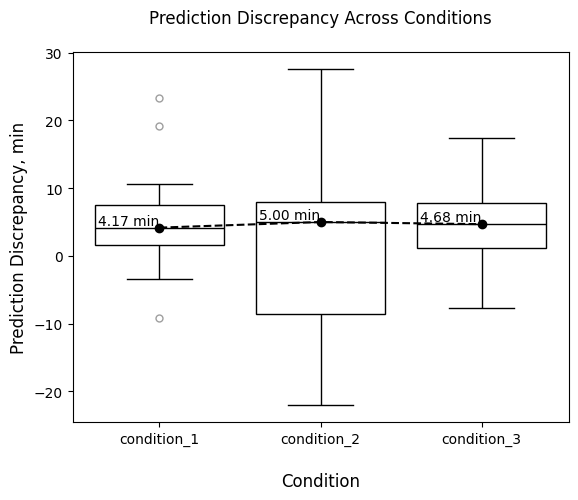

In [32]:
# medians and stds
h3_medians = all_data.query('condition!="control"')\
.groupby('condition').agg({'error':'median'}).reset_index().rename(columns={'error':'medians', 'h2_condition':'condition'})

h3_medians['std'] = [all_data.query(f"condition==@i")['error'].std() 
                     for i in h3_medians.condition.unique()]

#plotting plotting plotting
sns.boxplot(x=all_data[all_data['condition']!='control']['condition'],
            y=all_data['error'],
            data = all_data,
            boxprops=dict(facecolor="white", edgecolor="black"), 
            whiskerprops=dict(color="black"), capprops=dict(color="black"),
            medianprops=dict(color="black"), flierprops=dict(marker='o', markersize=5, alpha=0.5))

plt.plot(h3_medians.condition, h3_medians.medians, color='black', linestyle='--', marker='o')

for i, txt in enumerate(h3_medians.medians):
    plt.text(h3_medians.condition[i], h3_medians.medians[i], f'{txt:.2f} min', 
             ha='right', va='bottom', color='black', fontsize=10)

plt.xlabel("\nCondition", fontsize=12)
plt.ylabel("Prediction Discrepancy, min", fontsize=12)
plt.title("Prediction Discrepancy Across Conditions\n", fontsize=12)

plt.show()

In [24]:
h3_medians

,condition,medians,std
0,condition_1,4.17,8.070103
1,condition_2,5.00,14.141162
2,condition_3,4.68,6.130537


### Result: No Statistical Difference

**We stick to H0** - There is no significant difference in `error` among the experimental groups

- See table `h3_medians` with medians and std for concrete numbers

----

<div style="background-color: lightblue; padding: 10px;">

# Part 3: Other Stuff

### 1) Do Skills Significantly Influence Intervention Effects? (Disclaimer: Not Significant)

In [25]:
# median prediction discrepancy in conditions by skill lecel
skills_medians = all_data[['simple_condition','skills','error']]\
.groupby(['simple_condition','skills']).agg({'error':'median'}).reset_index()\
.pivot(index='skills', columns='simple_condition', values='error')
skills_medians.columns.name = None

skills_medians = skills_medians.style\
.set_caption('<b>Median Prediction Discrepancy by Skill<b>')
skills_medians

,control,experiment
skills,,
Advanced,16.015000,3.050000
Beginner,nan,2.250000
Expert,24.930000,5.570000
Intermediate,19.460000,7.360000


Overall, the difference doesn't seem to be significant across skill levels - however, we can see difference in prediction discrepancy across conditions (see H1)

In [26]:
skill_conditions = [all_data[all_data['skills']==i][['skills','error']]
                    for i in all_data['skills'].unique()]

#checking normal distribution
pvalues = []
for i in range(len(skill_conditions)):
    score = shapiro(skill_conditions[i]['error']).pvalue
    pvalues.append(score)
    print(f"Shapiro test p-value: {score}")
normality = True
for i in pvalues:
    if not i>0.05:
        normality==False
print(f"Normality: {normality}")

# checking for homogeneity of variance
stat, p = levene(*[skill_conditions[i]['error'] for i in range(len(skill_conditions))])
print(f"\nLevene’s Test p-value: {p}")
print(f"Homogeneity: {p>0.05}")

Shapiro test p-value: 0.43629622273481816
Shapiro test p-value: 0.558813394881413
Shapiro test p-value: 0.7610715463214623
Shapiro test p-value: nan
Normality: True

Levene’s Test p-value: 0.37094369398861365
Homogeneity: True


C:\Users\ltopuser\AppData\Local\Temp\ipykernel_4108\1576609075.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  score = shapiro(skill_conditions[i]['error']).pvalue


Even though, both tests pass here, let's consider the distributions non-normal, because "Beginner" skill doesn't have a normality value. So let's choose **Kruskal-Wallis Test** (non-parametric for multiple groups).

In [27]:
# Kruskal-Wallis
h_stat, kw_p = stats.kruskal(*[skill_conditions[i]['error'] for i in range(len(skill_conditions))])
print(f"Kruskal-Wallis test: p={kw_p}")
print(f"Significance: {kw_p<0.05}")

Kruskal-Wallis test: p=0.27368449329362027
Significance: False


**SKills do not statistically influence the planning error**

### Result: No Significant Difference

**We stick to H0** - Skills in presentation don't significantly influence planning

### 2) New H2 - Error Pre and Error Post Comparison (Disclaimer: Significant!)

Q `measure_actual` is significantly closer to the `measure_pre` (pre-intervention prediction) or `measure_post`(post-intervention prediction)

> **H1**: Significant difference between pre- and post-intervention prediction discrepancy (`error_pre` vs `error_post`) <p>
> **H0**: No significant difference


In [28]:
errors_data = all_data[['simple_condition', 'measure_pre', 'measure_post', 'measure_actual']].copy()\
.query('simple_condition=="experiment"')
errors_data['error_pre'] = errors_data['measure_actual'] - errors_data['measure_pre']
errors_data['error_post'] = errors_data['measure_actual'] - errors_data['measure_post']

# medians and std's in pre-intervention and post-intervention prediction discrepancy values 
errors_median = errors_data.agg({'error_pre':'median','error_post':'median'}).reset_index().rename(columns={'index':'error',0:'medians'})
errors_median['std'] = [errors_data.error_pre.std(), errors_data.error_pre.std()]
errors_median

errors_table = errors_median.style\
.set_caption('<b>Pre-/ Post- Intervention Prediction Discrepancy<b>')
errors_table

,error,medians,std
0,error_pre,10.000000,10.836558
1,error_post,4.680000,10.836558


In [29]:
# just quickly checking p-values
print(shapiro(errors_data.error_pre).pvalue)
print(shapiro(errors_data.error_post).pvalue)

0.7368702437833269
0.04277747303125376


Not everything is normally distributed, so **Mann-Whitney**:

In [30]:
# Mann-Whitney
u, p = mannwhitneyu(errors_data.error_pre, errors_data.error_post)
print(f"Mann-Whitney Test p-value: {p}")
print(f"Significance: {p<0.05}")

Mann-Whitney Test p-value: 0.0022536436784814473
Significance: True


The results are **statistically significant**, so on to plotting

Text(0.5, 1.0, 'Pre-/ Post-Intervention Prediction Discrepancy\n')

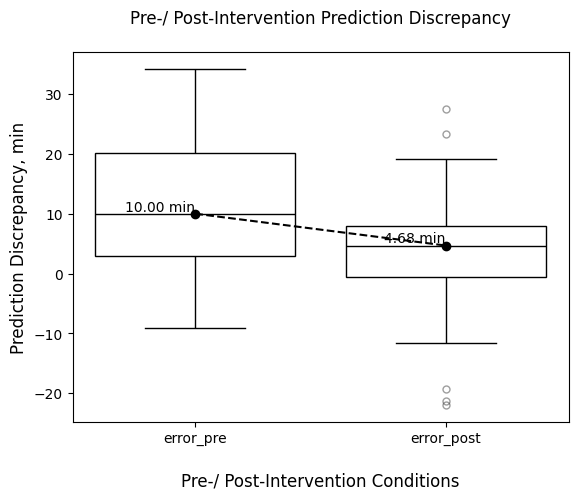

In [31]:
# plotting plotting plotting
sns.boxplot(errors_data[['error_pre','error_post']],
           boxprops=dict(facecolor="white", edgecolor="black"), 
           whiskerprops=dict(color="black"), capprops=dict(color="black"),
           medianprops=dict(color="black"), flierprops=dict(marker='o', markersize=5, alpha=0.5))

plt.plot(errors_median.error, errors_median.medians, color='black', linestyle='--', marker='o')

for i, txt in enumerate(errors_median.medians):
    plt.text(errors_median.error[i], errors_median.medians[i], f'{txt:.2f} min', 
             ha='right', va='bottom', color='black', fontsize=10)

plt.xlabel("\nPre-/ Post-Intervention Conditions", fontsize=12)
plt.ylabel("Prediction Discrepancy, min", fontsize=12)
plt.title("Pre-/ Post-Intervention Prediction Discrepancy\n", fontsize=12)

### Result: Statistically Significant Difference

**We accept H1** - Significant difference between pre- and post-intervention prediction discrepancy (`error_pre` vs `error_post`) <p>

- See table `errors_table` with medians and std for concrete numbers